### Imports




In [150]:
import math
import os
import copy
import time
import warnings
import torch

from tempfile import TemporaryDirectory
from typing import Tuple
from typing import List
from typing import Optional, Tuple
from typing import Optional, Any, Union, Callable

from torch import nn, Tensor
from torch.nn import functional as F
from torch.utils.data import dataset
from transformers import PreTrainedModel
from torch.nn.modules.linear import NonDynamicallyQuantizableLinear
from torch.nn.init import constant_, xavier_normal_, xavier_uniform_
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.nn.modules.container import ModuleList
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.linear import Linear
from torch.nn.modules.normalization import LayerNorm
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from transformers import PretrainedConfig
from transformers import OpenAIGPTConfig, AutoTokenizer, OpenAIGPTLMHeadModel 

from datasets import load_dataset
import matplotlib.pyplot as plt

### Copied from torch transformer implementation, because we want to customize some outputs

In [145]:
class MultiheadAttention(Module):
    r"""Allows the model to jointly attend to information
    from different representation subspaces as described in the paper:
    `Attention Is All You Need <https://arxiv.org/abs/1706.03762>`_.
    Multi-Head Attention is defined as:
    .. math::
        \text{MultiHead}(Q, K, V) = \text{Concat}(head_1,\dots,head_h)W^O
    where :math:`head_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)`.
    ``forward()`` will use a special optimized implementation if all of the following
    conditions are met:
    - self attention is being computed (i.e., ``query``, ``key``, and ``value`` are the same tensor. This
      restriction will be loosened in the future.)
    - Either autograd is disabled (using ``torch.inference_mode`` or ``torch.no_grad``) or no tensor argument ``requires_grad``
    - training is disabled (using ``.eval()``)
    - dropout is 0
    - ``add_bias_kv`` is ``False``
    - ``add_zero_attn`` is ``False``
    - ``batch_first`` is ``True`` and the input is batched
    - ``kdim`` and ``vdim`` are equal to ``embed_dim``
    - at most one of ``key_padding_mask`` or ``attn_mask`` is passed
    - if a `NestedTensor <https://pytorch.org/docs/stable/nested.html>`_ is passed, neither ``key_padding_mask``
      nor ``attn_mask`` is passed
    If the optimized implementation is in use, a
    `NestedTensor <https://pytorch.org/docs/stable/nested.html>`_ can be passed for
    ``query``/``key``/``value`` to represent padding more efficiently than using a
    padding mask. In this case, a `NestedTensor <https://pytorch.org/docs/stable/nested.html>`_
    will be returned, and an additional speedup proportional to the fraction of the input
    that is padding can be expected.
    Args:
        embed_dim: Total dimension of the model.
        num_heads: Number of parallel attention heads. Note that ``embed_dim`` will be split
            across ``num_heads`` (i.e. each head will have dimension ``embed_dim // num_heads``).
        dropout: Dropout probability on ``attn_output_weights``. Default: ``0.0`` (no dropout).
        bias: If specified, adds bias to input / output projection layers. Default: ``True``.
        add_bias_kv: If specified, adds bias to the key and value sequences at dim=0. Default: ``False``.
        add_zero_attn: If specified, adds a new batch of zeros to the key and value sequences at dim=1.
            Default: ``False``.
        kdim: Total number of features for keys. Default: ``None`` (uses ``kdim=embed_dim``).
        vdim: Total number of features for values. Default: ``None`` (uses ``vdim=embed_dim``).
        batch_first: If ``True``, then the input and output tensors are provided
            as (batch, seq, feature). Default: ``False`` (seq, batch, feature).
    Examples::
        >>> multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
        >>> attn_output, attn_output_weights = multihead_attn(query, key, value)
    """
    __constants__ = ['batch_first']
    bias_k: Optional[torch.Tensor]
    bias_v: Optional[torch.Tensor]

    def __init__(self, embed_dim, num_heads, dropout=0., bias=True, add_bias_kv=False, add_zero_attn=False,
                 kdim=None, vdim=None, batch_first=False, device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(MultiheadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.kdim = kdim if kdim is not None else embed_dim
        self.vdim = vdim if vdim is not None else embed_dim
        self._qkv_same_embed_dim = self.kdim == embed_dim and self.vdim == embed_dim

        self.num_heads = num_heads
        self.dropout = dropout
        self.batch_first = batch_first
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"

        if self._qkv_same_embed_dim is False:
            self.q_proj_weight = Parameter(torch.empty((embed_dim, embed_dim), **factory_kwargs))
            self.k_proj_weight = Parameter(torch.empty((embed_dim, self.kdim), **factory_kwargs))
            self.v_proj_weight = Parameter(torch.empty((embed_dim, self.vdim), **factory_kwargs))
            self.register_parameter('in_proj_weight', None)
        else:
            self.in_proj_weight = Parameter(torch.empty((3 * embed_dim, embed_dim), **factory_kwargs))
            self.register_parameter('q_proj_weight', None)
            self.register_parameter('k_proj_weight', None)
            self.register_parameter('v_proj_weight', None)

        if bias:
            self.in_proj_bias = Parameter(torch.empty(3 * embed_dim, **factory_kwargs))
        else:
            self.register_parameter('in_proj_bias', None)
        self.out_proj = NonDynamicallyQuantizableLinear(embed_dim, embed_dim, bias=bias, **factory_kwargs)

        if add_bias_kv:
            self.bias_k = Parameter(torch.empty((1, 1, embed_dim), **factory_kwargs))
            self.bias_v = Parameter(torch.empty((1, 1, embed_dim), **factory_kwargs))
        else:
            self.bias_k = self.bias_v = None

        self.add_zero_attn = add_zero_attn
        
        
#         self.linear1 = Linear(embed_dim, embed_dim, **factory_kwargs)
#         self.linear2 = Linear(embed_dim, embed_dim, **factory_kwargs)
#         self.linear3 = Linear(embed_dim, embed_dim, **factory_kwargs)
#         self.activation = F.relu
#         self.dropout2 = Dropout(0.3)

        self._reset_parameters()

    def _reset_parameters(self):
        if self._qkv_same_embed_dim:
            xavier_uniform_(self.in_proj_weight)
        else:
            xavier_uniform_(self.q_proj_weight)
            xavier_uniform_(self.k_proj_weight)
            xavier_uniform_(self.v_proj_weight)

        if self.in_proj_bias is not None:
            constant_(self.in_proj_bias, 0.)
            constant_(self.out_proj.bias, 0.)
        if self.bias_k is not None:
            xavier_normal_(self.bias_k)
        if self.bias_v is not None:
            xavier_normal_(self.bias_v)

    def __setstate__(self, state):
        # Support loading old MultiheadAttention checkpoints generated by v1.1.0
        if '_qkv_same_embed_dim' not in state:
            state['_qkv_same_embed_dim'] = True

        super(MultiheadAttention, self).__setstate__(state)

    def forward(self, query: Tensor, key: Tensor, value: Tensor, key_padding_mask: Optional[Tensor] = None,
                need_weights: bool = True, attn_mask: Optional[Tensor] = None,
                average_attn_weights: bool = True) -> Tuple[Tensor, Optional[Tensor]]:
        r"""
    Args:
        query: Query embeddings of shape :math:`(L, E_q)` for unbatched input, :math:`(L, N, E_q)` when ``batch_first=False``
            or :math:`(N, L, E_q)` when ``batch_first=True``, where :math:`L` is the target sequence length,
            :math:`N` is the batch size, and :math:`E_q` is the query embedding dimension ``embed_dim``.
            Queries are compared against key-value pairs to produce the output.
            See "Attention Is All You Need" for more details.
        key: Key embeddings of shape :math:`(S, E_k)` for unbatched input, :math:`(S, N, E_k)` when ``batch_first=False``
            or :math:`(N, S, E_k)` when ``batch_first=True``, where :math:`S` is the source sequence length,
            :math:`N` is the batch size, and :math:`E_k` is the key embedding dimension ``kdim``.
            See "Attention Is All You Need" for more details.
        value: Value embeddings of shape :math:`(S, E_v)` for unbatched input, :math:`(S, N, E_v)` when
            ``batch_first=False`` or :math:`(N, S, E_v)` when ``batch_first=True``, where :math:`S` is the source
            sequence length, :math:`N` is the batch size, and :math:`E_v` is the value embedding dimension ``vdim``.
            See "Attention Is All You Need" for more details.
        key_padding_mask: If specified, a mask of shape :math:`(N, S)` indicating which elements within ``key``
            to ignore for the purpose of attention (i.e. treat as "padding"). For unbatched `query`, shape should be :math:`(S)`.
            Binary and byte masks are supported.
            For a binary mask, a ``True`` value indicates that the corresponding ``key`` value will be ignored for
            the purpose of attention. For a byte mask, a non-zero value indicates that the corresponding ``key``
            value will be ignored.
        need_weights: If specified, returns ``attn_output_weights`` in addition to ``attn_outputs``.
            Default: ``True``.
        attn_mask: If specified, a 2D or 3D mask preventing attention to certain positions. Must be of shape
            :math:`(L, S)` or :math:`(N\cdot\text{num\_heads}, L, S)`, where :math:`N` is the batch size,
            :math:`L` is the target sequence length, and :math:`S` is the source sequence length. A 2D mask will be
            broadcasted across the batch while a 3D mask allows for a different mask for each entry in the batch.
            Binary, byte, and float masks are supported. For a binary mask, a ``True`` value indicates that the
            corresponding position is not allowed to attend. For a byte mask, a non-zero value indicates that the
            corresponding position is not allowed to attend. For a float mask, the mask values will be added to
            the attention weight.
        average_attn_weights: If true, indicates that the returned ``attn_weights`` should be averaged across
            heads. Otherwise, ``attn_weights`` are provided separately per head. Note that this flag only has an
            effect when ``need_weights=True``. Default: ``True`` (i.e. average weights across heads)
    Outputs:
        - **attn_output** - Attention outputs of shape :math:`(L, E)` when input is unbatched,
          :math:`(L, N, E)` when ``batch_first=False`` or :math:`(N, L, E)` when ``batch_first=True``,
          where :math:`L` is the target sequence length, :math:`N` is the batch size, and :math:`E` is the
          embedding dimension ``embed_dim``.
        - **attn_output_weights** - Only returned when ``need_weights=True``. If ``average_attn_weights=True``,
          returns attention weights averaged across heads of shape :math:`(L, S)` when input is unbatched or
          :math:`(N, L, S)`, where :math:`N` is the batch size, :math:`L` is the target sequence length, and
          :math:`S` is the source sequence length. If ``average_weights=False``, returns attention weights per
          head of shape :math:`(\text{num\_heads}, L, S)` when input is unbatched or :math:`(N, \text{num\_heads}, L, S)`.
        .. note::
            `batch_first` argument is ignored for unbatched inputs.
        """
        

        is_batched = query.dim() == 3
        why_not_fast_path = ''
        if not is_batched:
            why_not_fast_path = f"input not batched; expected query.dim() of 3 but got {query.dim()}"
        elif query is not key or key is not value:
            # When lifting this restriction, don't forget to either
            # enforce that the dtypes all match or test cases where
            # they don't!
            why_not_fast_path = "non-self attention was used (query, key, and value are not the same Tensor)"
        elif self.in_proj_bias is not None and query.dtype != self.in_proj_bias.dtype:
            why_not_fast_path = f"dtypes of query ({query.dtype}) and self.in_proj_bias ({self.in_proj_bias.dtype}) don't match"
        elif self.in_proj_weight is not None and query.dtype != self.in_proj_weight.dtype:
            # this case will fail anyway, but at least they'll get a useful error message.
            why_not_fast_path = f"dtypes of query ({query.dtype}) and self.in_proj_weight ({self.in_proj_weight.dtype}) don't match"
        elif self.training:
            why_not_fast_path = "training is enabled"
        elif not self.batch_first:
            why_not_fast_path = "batch_first was not True"
        elif self.bias_k is not None:
            why_not_fast_path = "self.bias_k was not None"
        elif self.bias_v is not None:
            why_not_fast_path = "self.bias_v was not None"
        elif self.dropout:
            why_not_fast_path = f"dropout was {self.dropout}, required zero"
        elif self.add_zero_attn:
            why_not_fast_path = "add_zero_attn was enabled"
        elif not self._qkv_same_embed_dim:
            why_not_fast_path = "_qkv_same_embed_dim was not True"
        elif attn_mask is not None:
            why_not_fast_path = "attn_mask was not None"
        elif query.is_nested and key_padding_mask is not None:
            why_not_fast_path = "key_padding_mask is not supported with NestedTensor input"

        if not why_not_fast_path:
            tensor_args = (
                query,
                key,
                value,
                self.in_proj_weight,
                self.in_proj_bias,
                self.out_proj.weight,
                self.out_proj.bias,
            )
            # We have to use list comprehensions below because TorchScript does not support
            # generator expressions.
            if torch.overrides.has_torch_function(tensor_args):
                why_not_fast_path = "some Tensor argument has_torch_function"
            elif not all([(x.is_cuda or 'cpu' in str(x.device)) for x in tensor_args]):
                why_not_fast_path = "some Tensor argument is neither CUDA nor CPU"
            elif torch.is_grad_enabled() and any([x.requires_grad for x in tensor_args]):
                why_not_fast_path = ("grad is enabled and at least one of query or the "
                                     "input/output projection weights or biases requires_grad")
            if not why_not_fast_path:
                return torch._native_multi_head_attention(
                    query,
                    key,
                    value,
                    self.embed_dim,
                    self.num_heads,
                    self.in_proj_weight,
                    self.in_proj_bias,
                    self.out_proj.weight,
                    self.out_proj.bias,
                    key_padding_mask if key_padding_mask is not None else attn_mask,
                    need_weights,
                    average_attn_weights)
        any_nested = query.is_nested or key.is_nested or value.is_nested
        assert not any_nested, ("MultiheadAttention does not support NestedTensor outside of its fast path. " +
                                f"The fast path was not hit because {why_not_fast_path}")

        if self.batch_first and is_batched:
            # make sure that the transpose op does not affect the "is" property
            if key is value:
                if query is key:
                    query = key = value = query.transpose(1, 0)
                else:
                    query, key = [x.transpose(1, 0) for x in (query, key)]
                    value = key
            else:
                query, key, value = [x.transpose(1, 0) for x in (query, key, value)]

#         query = self.dropout2(self.activation(self.linear1(query)))  
#         key = self.dropout2(self.activation(self.linear2(key)))  
#         value = self.dropout2(self.activation(self.linear3(value)))  
        
        if not self._qkv_same_embed_dim:
            attn_output, attn_output_weights = F.multi_head_attention_forward(
                query, key, value, self.embed_dim, self.num_heads,
                self.in_proj_weight, self.in_proj_bias,
                self.bias_k, self.bias_v, self.add_zero_attn,
                self.dropout, self.out_proj.weight, self.out_proj.bias,
                training=self.training,
                key_padding_mask=key_padding_mask, need_weights=need_weights,
                attn_mask=attn_mask, use_separate_proj_weight=True,
                q_proj_weight=self.q_proj_weight, k_proj_weight=self.k_proj_weight,
                v_proj_weight=self.v_proj_weight, average_attn_weights=average_attn_weights)
        else:
            attn_output, attn_output_weights = F.multi_head_attention_forward(
                query, key, value, self.embed_dim, self.num_heads,
                self.in_proj_weight, self.in_proj_bias,
                self.bias_k, self.bias_v, self.add_zero_attn,
                self.dropout, self.out_proj.weight, self.out_proj.bias,
                training=self.training,
                key_padding_mask=key_padding_mask, need_weights=need_weights,
                attn_mask=attn_mask, average_attn_weights=average_attn_weights)
        
        if self.batch_first and is_batched:
            return attn_output.transpose(1, 0), attn_output_weights
        else:
            return attn_output, attn_output_weights
                

In [146]:
def _get_clones(module, N):
    # FIXME: copy.deepcopy() is not defined on nn.module
    return ModuleList([copy.deepcopy(module) for i in range(N)])

class TransformerEncoder(Module):
    r"""TransformerEncoder is a stack of N encoder layers
    Args:
        encoder_layer: an instance of the TransformerEncoderLayer() class (required).
        num_layers: the number of sub-encoder-layers in the encoder (required).
        norm: the layer normalization component (optional).
        enable_nested_tensor: if True, input will automatically convert to nested tensor
            (and convert back on output). This will improve the overall performance of
            TransformerEncoder when padding rate is high. Default: ``False`` (disabled).
    Examples::
        >>> encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        >>> transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
        >>> src = torch.rand(10, 32, 512)
        >>> out = transformer_encoder(src)
    """
    __constants__ = ['norm']

    def __init__(self, encoder_layer, num_layers, norm=None, enable_nested_tensor=False):
        super(TransformerEncoder, self).__init__()
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm
        self.enable_nested_tensor = enable_nested_tensor

    def forward(self, src: Tensor, mask: Optional[Tensor] = None, src_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        r"""Pass the input through the encoder layers in turn.
        Args:
            src: the sequence to the encoder (required).
            mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).
        Shape:
            see the docs in Transformer class.
        """
        output = src
        convert_to_nested = False
        first_layer = self.layers[0]
        if isinstance(first_layer, torch.nn.TransformerEncoderLayer):
            if (not first_layer.norm_first and not first_layer.training and
                    first_layer.self_attn.batch_first and
                    first_layer.self_attn._qkv_same_embed_dim and first_layer.activation_relu_or_gelu and
                    first_layer.norm1.eps == first_layer.norm2.eps and
                    src.dim() == 3 and self.enable_nested_tensor) :
                if src_key_padding_mask is not None and not output.is_nested and mask is None:
                    tensor_args = (
                        src,
                        first_layer.self_attn.in_proj_weight,
                        first_layer.self_attn.in_proj_bias,
                        first_layer.self_attn.out_proj.weight,
                        first_layer.self_attn.out_proj.bias,
                        first_layer.norm1.weight,
                        first_layer.norm1.bias,
                        first_layer.norm2.weight,
                        first_layer.norm2.bias,
                        first_layer.linear1.weight,
                        first_layer.linear1.bias,
                        first_layer.linear2.weight,
                        first_layer.linear2.bias,
                    )
                    if not torch.overrides.has_torch_function(tensor_args):
                        if not torch.is_grad_enabled() or all([not x.requires_grad for x in tensor_args]):
                            if output.is_cuda or 'cpu' in str(output.device):
                                convert_to_nested = True
                                output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not())
        attentions = []
        for mod in self.layers:
            if convert_to_nested:
                output = mod(output, src_mask=mask)
            else:
                output, attention = mod(output, src_mask=mask, src_key_padding_mask=src_key_padding_mask)
                attentions.append(attention)
        if convert_to_nested:
            output = output.to_padded_tensor(0.)

        if self.norm is not None:
            output = self.norm(output)

        return output, attentions


class TransformerDecoder(Module):
    r"""TransformerDecoder is a stack of N decoder layers
    Args:
        decoder_layer: an instance of the TransformerDecoderLayer() class (required).
        num_layers: the number of sub-decoder-layers in the decoder (required).
        norm: the layer normalization component (optional).
    Examples::
        >>> decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=8)
        >>> transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
        >>> memory = torch.rand(10, 32, 512)
        >>> tgt = torch.rand(20, 32, 512)
        >>> out = transformer_decoder(tgt, memory)
    """
    __constants__ = ['norm']

    def __init__(self, decoder_layer, num_layers, norm=None):
        super(TransformerDecoder, self).__init__()
        self.layers = _get_clones(decoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, tgt: Tensor, memory: Tensor, tgt_mask: Optional[Tensor] = None,
                memory_mask: Optional[Tensor] = None, tgt_key_padding_mask: Optional[Tensor] = None,
                memory_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        r"""Pass the inputs (and mask) through the decoder layer in turn.
        Args:
            tgt: the sequence to the decoder (required).
            memory: the sequence from the last layer of the encoder (required).
            tgt_mask: the mask for the tgt sequence (optional).
            memory_mask: the mask for the memory sequence (optional).
            tgt_key_padding_mask: the mask for the tgt keys per batch (optional).
            memory_key_padding_mask: the mask for the memory keys per batch (optional).
        Shape:
            see the docs in Transformer class.
        """
        output = tgt

        for mod in self.layers:
            output = mod(output, memory, tgt_mask=tgt_mask,
                         memory_mask=memory_mask,
                         tgt_key_padding_mask=tgt_key_padding_mask,
                         memory_key_padding_mask=memory_key_padding_mask)

        if self.norm is not None:
            output = self.norm(output)

        return output

class TransformerEncoderLayer(Module):
    r"""TransformerEncoderLayer is made up of self-attn and feedforward network.
    This standard encoder layer is based on the paper "Attention Is All You Need".
    Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez,
    Lukasz Kaiser, and Illia Polosukhin. 2017. Attention is all you need. In Advances in
    Neural Information Processing Systems, pages 6000-6010. Users may modify or implement
    in a different way during application.
    Args:
        d_model: the number of expected features in the input (required).
        nhead: the number of heads in the multiheadattention models (required).
        dim_feedforward: the dimension of the feedforward network model (default=2048).
        dropout: the dropout value (default=0.1).
        activation: the activation function of the intermediate layer, can be a string
            ("relu" or "gelu") or a unary callable. Default: relu
        layer_norm_eps: the eps value in layer normalization components (default=1e-5).
        batch_first: If ``True``, then the input and output tensors are provided
            as (batch, seq, feature). Default: ``False`` (seq, batch, feature).
        norm_first: if ``True``, layer norm is done prior to attention and feedforward
            operations, respectivaly. Otherwise it's done after. Default: ``False`` (after).
    Examples::
        >>> encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        >>> src = torch.rand(10, 32, 512)
        >>> out = encoder_layer(src)
    Alternatively, when ``batch_first`` is ``True``:
        >>> encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8, batch_first=True)
        >>> src = torch.rand(32, 10, 512)
        >>> out = encoder_layer(src)
    Fast path:
        forward() will use a special optimized implementation if all of the following
        conditions are met:
        - Either autograd is disabled (using ``torch.inference_mode`` or ``torch.no_grad``) or no tensor
          argument ``requires_grad``
        - training is disabled (using ``.eval()``)
        - batch_first is ``True`` and the input is batched (i.e., ``src.dim() == 3``)
        - norm_first is ``False`` (this restriction may be loosened in the future)
        - activation is one of: ``"relu"``, ``"gelu"``, ``torch.functional.relu``, or ``torch.functional.gelu``
        - at most one of ``src_mask`` and ``src_key_padding_mask`` is passed
        - if src is a `NestedTensor <https://pytorch.org/docs/stable/nested.html>`_, neither ``src_mask``
          nor ``src_key_padding_mask`` is passed
        - the two ``LayerNorm`` instances have a consistent ``eps`` value (this will naturally be the case
          unless the caller has manually modified one without modifying the other)
        If the optimized implementation is in use, a
        `NestedTensor <https://pytorch.org/docs/stable/nested.html>`_ can be
        passed for ``src`` to represent padding more efficiently than using a padding
        mask. In this case, a `NestedTensor <https://pytorch.org/docs/stable/nested.html>`_ will be
        returned, and an additional speedup proportional to the fraction of the input that
        is padding can be expected.
    """
    __constants__ = ['batch_first', 'norm_first']

    def __init__(self, d_model: int, nhead: int, dim_feedforward: int = 2048, dropout: float = 0.1,
                 activation: Union[str, Callable[[Tensor], Tensor]] = F.relu,
                 layer_norm_eps: float = 1e-5, batch_first: bool = False, norm_first: bool = False,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first,
                                            **factory_kwargs)
        # Implementation of Feedforward model
        self.linear1 = Linear(d_model, dim_feedforward, **factory_kwargs)
        self.dropout = Dropout(dropout)
        self.linear2 = Linear(dim_feedforward, d_model, **factory_kwargs)

        self.norm_first = norm_first
        self.norm1 = LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.norm2 = LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

        # Legacy string support for activation function.
        if isinstance(activation, str):
            activation = _get_activation_fn(activation)

        # We can't test self.activation in forward() in TorchScript,
        # so stash some information about it instead.
        if activation is F.relu:
            self.activation_relu_or_gelu = 1
        elif activation is F.gelu:
            self.activation_relu_or_gelu = 2
        else:
            self.activation_relu_or_gelu = 0
        self.activation = activation

    def __setstate__(self, state):
        super(TransformerEncoderLayer, self).__setstate__(state)
        if not hasattr(self, 'activation'):
            self.activation = F.relu


    def forward(self, src: Tensor, src_mask: Optional[Tensor] = None,
                src_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        r"""Pass the input through the encoder layer.
        Args:
            src: the sequence to the encoder layer (required).
            src_mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).
        Shape:
            see the docs in Transformer class.
        """

        # see Fig. 1 of https://arxiv.org/pdf/2002.04745v1.pdf

        if (src.dim() == 3 and not self.norm_first and not self.training and
            self.self_attn.batch_first and
            self.self_attn._qkv_same_embed_dim and self.activation_relu_or_gelu and
            self.norm1.eps == self.norm2.eps and
            src_mask is None and
                not (src.is_nested and src_key_padding_mask is not None)):
            tensor_args = (
                src,
                self.self_attn.in_proj_weight,
                self.self_attn.in_proj_bias,
                self.self_attn.out_proj.weight,
                self.self_attn.out_proj.bias,
                self.norm1.weight,
                self.norm1.bias,
                self.norm2.weight,
                self.norm2.bias,
                self.linear1.weight,
                self.linear1.bias,
                self.linear2.weight,
                self.linear2.bias,
            )
            if (not torch.overrides.has_torch_function(tensor_args) and
                    # We have to use a list comprehension here because TorchScript
                    # doesn't support generator expressions.
                    all([(x.is_cuda or 'cpu' in str(x.device)) for x in tensor_args]) and
                    (not torch.is_grad_enabled() or all([not x.requires_grad for x in tensor_args]))):
                return torch._transformer_encoder_layer_fwd(
                    src,
                    self.self_attn.embed_dim,
                    self.self_attn.num_heads,
                    self.self_attn.in_proj_weight,
                    self.self_attn.in_proj_bias,
                    self.self_attn.out_proj.weight,
                    self.self_attn.out_proj.bias,
                    self.activation_relu_or_gelu == 2,
                    False,  # norm_first, currently not supported
                    self.norm1.eps,
                    self.norm1.weight,
                    self.norm1.bias,
                    self.norm2.weight,
                    self.norm2.bias,
                    self.linear1.weight,
                    self.linear1.bias,
                    self.linear2.weight,
                    self.linear2.bias,
                    src_mask if src_mask is not None else src_key_padding_mask,  # TODO: split into two args
                )
        x = src
        if self.norm_first:
            output, attention = self._sa_block(self.norm1(x), src_mask, src_key_padding_mask)
            x = x + output
            x = x + self._ff_block(self.norm2(x))
        else:
            output, attention = self._sa_block(x, src_mask, src_key_padding_mask)
            x = self.norm1(x + output)
            x = self.norm2(x + self._ff_block(x))

        return x, attention

    # self-attention block
    def _sa_block(self, x: Tensor,
                  attn_mask: Optional[Tensor], key_padding_mask: Optional[Tensor]) -> Tensor:
        x, attn = self.self_attn(x, x, x,
                           attn_mask=attn_mask,
                           key_padding_mask=key_padding_mask,
                           need_weights=True)
        return self.dropout1(x), attn

    # feed forward block
    def _ff_block(self, x: Tensor) -> Tensor:
        x = self.linear2(self.dropout(self.activation(self.linear1(x))))
        return self.dropout2(x)




In [131]:
class TransConfig(PretrainedConfig):
    model_type = "transformer"

    def __init__(
        self,
        ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5,
        **kwargs,
    ):
        self.ntoken = ntoken
        self.d_model = d_model
        self.nhead = nhead
        self.d_hid = d_hid
        self.nlayers = nlayers
        self.dropout=dropout
        super().__init__(**kwargs)

class TransformerModel(PreTrainedModel):
    
    config_class = TransConfig
    
    def __init__(self, config):
        super().__init__(config)
        self.model_type = config.model_type
        self.pos_encoder = PositionalEncoding(config.d_model, config.dropout)
        encoder_layers = TransformerEncoderLayer(config.d_model, config.nhead, config.d_hid, config.dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, config.nlayers)
        self.encoder = nn.Embedding(config.ntoken, config.d_model)
        self.d_model = config.d_model
        self.decoder = nn.Linear(config.d_model, config.ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        """
        Arguments:
            src: Tensor, shape ``[seq_len, batch_size]``
            src_mask: Tensor, shape ``[seq_len, seq_len]``

        Returns:
            output Tensor of shape ``[seq_len, batch_size, ntoken]``
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output, attention = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output, attention


def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of ``-inf``, with zeros on ``diag``."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)


class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

### Copied from transformer tutorial 
https://pytorch.org/tutorials/beginner/transformer_tutorial.html)

In [149]:
train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    """Converts raw text into a flat Tensor."""
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

# ``train_iter`` was "consumed" by the process of building the vocab,
# so we have to create it again
train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def batchify(data: Tensor, bsz: int) -> Tensor:
    """Divides the data into ``bsz`` separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Arguments:
        data: Tensor, shape [N]
        bsz: int, batch size

    Returns:
        Tensor of shape ``[N // bsz, bsz]``
    """
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape ``[full_seq_len, batch_size]``
        i: int

    Returns:
        tuple (data, target), where data has shape ``[seq_len, batch_size]`` and
        target has shape ``[seq_len * batch_size]``
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)  # shape ``[seq_len, batch_size]``
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)
bptt = 35


device = torch.device('cuda')
    
ntokens = len(vocab)  # size of vocabulary
emsize = 200  # embedding dimension
d_hid = 200  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 1  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 1  # number of heads in ``nn.MultiheadAttention``
dropout = 0.3  # dropout probability
config = TransConfig(ntokens, emsize, nhead, d_hid, nlayers, dropout)
model = TransformerModel(config).to(device)

my_list = ['transformer_encoder.layers.0.linear1.weight',
'transformer_encoder.layers.0.linear1.bias',
'transformer_encoder.layers.0.linear2.weight',
'transformer_encoder.layers.0.linear2.bias']
params = list(filter(lambda kv: kv[0] in my_list, model.named_parameters()))
base_params = list(filter(lambda kv: kv[0] not in my_list, model.named_parameters()))


### Training Loop

In [141]:
criterion = nn.CrossEntropyLoss()
lr = 1  # learning rate
optimizer = torch.optim.SGD([{'params': [temp[1] for temp in params], 'lr': 10}, {'params': [temp[1] for temp in base_params], 'lr': 5}])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train(model: nn.Module, epoch=0) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 100
    start_time = time.time()
    src_mask = generate_square_subsequent_mask(bptt).to(device)

    num_batches = len(train_data) // bptt
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        
        if (batch+(epoch-1)*num_batches) % log_interval == 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()
            best_model_params_path = os.path.join('hello', f'model_medium_iter_{batch+(epoch-1)*num_batches}.pt')
            torch.save(model.state_dict(), best_model_params_path)
        data, targets = get_batch(train_data, i)
        seq_len = data.size(0)
        if seq_len != bptt:  # only on last batch
            src_mask = src_mask[:seq_len, :seq_len]
        output, attention = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()


def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    src_mask = generate_square_subsequent_mask(bptt).to(device)
    return_attn = 0
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            seq_len = data.size(0)
            if seq_len != bptt:
                src_mask = src_mask[:seq_len, :seq_len]
            output, attention = model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += seq_len * criterion(output_flat, targets).item()
            if i==100*bptt:
                return_attn = attention
                print(data[:,0])
                break
    return total_loss / (len(eval_data) - 1), return_attn


### We are evaluating the model we just saved during the training. And we're going to save some tensors we plan to plot.

In [143]:
collections = {}

for i in range(0, 2000, 100):
    best_model_params_path = os.path.join('hello', f'model_medium_iter_{i}.pt')
    model.load_state_dict(torch.load(best_model_params_path))
    test_loss, attn = evaluate(model, train_data)
    test_ppl = math.exp(test_loss)
    print('=' * 89)
    print(f'| End of training | test loss {test_loss:5.2f} | '
          f'test ppl {test_ppl:8.2f}')
    print('=' * 89)
    collections['iter_'+str(i)] = attn

tensor([   43,  6971,     3,    66,   407,     1,  3476,     2,     1,   319,
          157,    29,   842,    19, 13722,     7,   294,    24,    14,  5902,
           14,   687,     2,    18,     1,  5832,    16,     1,   157,   162,
         1963,   735,    60,  1946,    89], device='cuda:0')
| End of training | test loss  0.37 | test ppl     1.44
tensor([   43,  6971,     3,    66,   407,     1,  3476,     2,     1,   319,
          157,    29,   842,    19, 13722,     7,   294,    24,    14,  5902,
           14,   687,     2,    18,     1,  5832,    16,     1,   157,   162,
         1963,   735,    60,  1946,    89], device='cuda:0')
| End of training | test loss  0.25 | test ppl     1.29
tensor([   43,  6971,     3,    66,   407,     1,  3476,     2,     1,   319,
          157,    29,   842,    19, 13722,     7,   294,    24,    14,  5902,
           14,   687,     2,    18,     1,  5832,    16,     1,   157,   162,
         1963,   735,    60,  1946,    89], device='cuda:0')
| E

tensor([   43,  6971,     3,    66,   407,     1,  3476,     2,     1,   319,
          157,    29,   842,    19, 13722,     7,   294,    24,    14,  5902,
           14,   687,     2,    18,     1,  5832,    16,     1,   157,   162,
         1963,   735,    60,  1946,    89], device='cuda:0')
| End of training | test loss  0.22 | test ppl     1.24
tensor([   43,  6971,     3,    66,   407,     1,  3476,     2,     1,   319,
          157,    29,   842,    19, 13722,     7,   294,    24,    14,  5902,
           14,   687,     2,    18,     1,  5832,    16,     1,   157,   162,
         1963,   735,    60,  1946,    89], device='cuda:0')
| End of training | test loss  0.22 | test ppl     1.25
tensor([   43,  6971,     3,    66,   407,     1,  3476,     2,     1,   319,
          157,    29,   842,    19, 13722,     7,   294,    24,    14,  5902,
           14,   687,     2,    18,     1,  5832,    16,     1,   157,   162,
         1963,   735,    60,  1946,    89], device='cuda:0')
| E

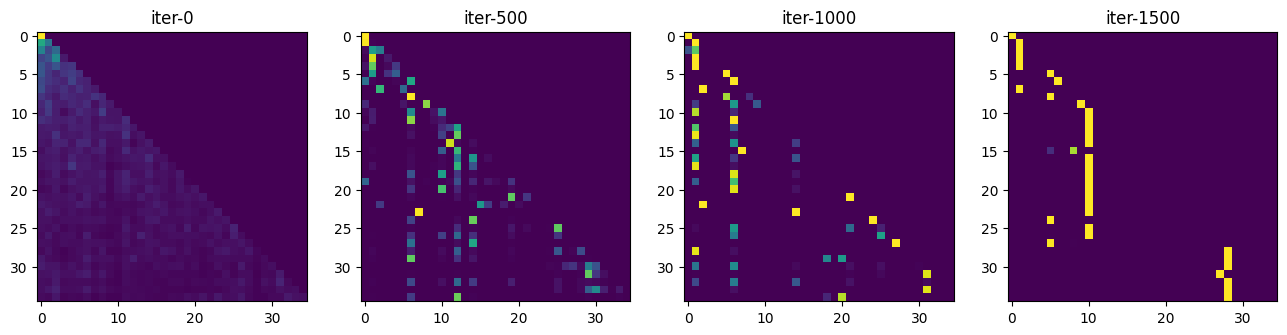

In [144]:
fig, axs = plt.subplots(1,4,figsize=(16,4))
layer = 0

for j in range(4):
    iteration = 0+500*(j)
    attn_map = collections['iter_'+str(iteration)][layer]
    axs[j].set_title("iter-"+str(iteration))
    axs[j].imshow(attn_map[0].cpu())
plt.savefig("layer"+ str(layer) +".pdf", format="pdf", bbox_inches="tight")